# Set Up

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yt
import pandas as pd
import trident as tr

In [ ]:
np.set_printoptions(precision=20)

In [ ]:
ds = yt.load( '/Users/chellhnl/FIRE_analysis/m12i_res7100/output/snapdir_600' )

In [ ]:
data = ds.all_data()

In [ ]:
tr.add_ion_fields(ds, ions=['O VI','C IV', 'Si II', 'Mg II','Na I'])

## The Center of Galaxy Using Halo Data

In [ ]:
halo_catalog_fp = '/Users/chellhnl/FIRE_analysis/m12i_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5'

import h5py
f = h5py.File( halo_catalog_fp, 'r' ) #f is a dictionary, so you can do f.keys()
index = f['mass'][...].argmax() 

#... means indexing all of it, because HDF5 doesn't show you everything unless you ask for it
#.argmax() gets the index of maximum.
#maximum mass is center because host galaxy is the one in the center so it should have the most mass.

center_ckpc = f['position'][...][index]
#the actual code to bring it to modern day, getting physical distance, is below. 
#not used because error but f[redshift] is 0 so it's basically center_ckpc

center = center_ckpc / ( 1. + f['snapshot:redshift'][...] )

kpc = ds.quan( 1, 'kpc' )
center_kpc=center*kpc

## Making the Sun the Origin Using Vector Math

In [ ]:
gas_coordinates = (data[('PartType0', 'Coordinates')]).in_units("kpc")

### First need to filter out really far star particles that are not in the galaxy

In [ ]:
#apply distance formula from each star coordinate to the center. if <150 kpc, it is within a good range.
distance_to_center=np.sqrt( (gas_coordinates[:,0]-center_kpc[0] )**2 + (gas_coordinates[:,1]-center_kpc[1])**2 +(gas_coordinates[:,2]-center_kpc[2])**2 )

within_range = distance_to_center < (150.*kpc)
galaxy_gas = gas_coordinates[within_range]


### Then do vector math, applying refined list of star coordinates

In [ ]:
# Get dataset units
kpc = ds.quan( 1, 'kpc' )

# Calculate the angular momentum (extracting a sphere around the galaxy first for it).
# `center` is the center of the galaxy in kpc.
sp = ds.sphere( center_kpc , (10, "kpc")) #10 is radius
jtot = sp.quantities.angular_momentum_vector( particle_type='PartType0' ).to( 'kpc * km / s' ).value

# Unit vectors for a frame w/ zhat aligned with the total angular momentum
zhat = jtot / np.linalg.norm( jtot ) #basically getting the unit vector by dividing jtot vector by its magnitude

#cross product of zhat and some vector to get a vector that's perpendicular to zhat (along galaxy disk):
xhat = np.cross( [ 1, 0, 0 ], zhat )
xhat /= np.linalg.norm( xhat )

# Sun position in simulation coordinates -> 8 kpc from center at an arbitrary angle
sun_position = center_kpc + (8. * xhat *kpc)

# Unit vectors for on-sky coordinate system.
# xskyhat points from the sun to the center of the galaxy.
# zskyhat points parallel to the axis of total angular momentum.
# yskyhat (should) point to the left on a sky map.
xskyhat = -xhat
zskyhat = zhat
yskyhat = np.cross( zskyhat, xskyhat )

# Given a series of positions (the undefined vector)
# shift them over, i.e. make a new frame centered on the sun.
positions_sun = galaxy_gas - sun_position

# And now rotate them to the sky frame
positions_sky = np.array([
    np.dot( positions_sun, xskyhat ), # Check the axis argument, this may not be right
    np.dot( positions_sun, yskyhat ),
    np.dot( positions_sun, zskyhat ),
    ]).transpose()

# Trident Column Density Maps

In [381]:
print(jtot) #in kpc
print(xhat*kpc)
print(sp.center)

[-0.4641237788797538 -0.195761311325276  -0.8638672507200316]
[ 0.                   0.9752722565175755  -0.22100684529470196] kpc
[29338.101914062492 30980.11007812499  32479.913882812492] code_length


### A PLOT FOR GAS DENSITY (NO IONS SPECIFIED)

yt : [INFO     ] 2022-10-19 11:48:12,868 xlim = -35.100000 35.100000
yt : [INFO     ] 2022-10-19 11:48:12,870 ylim = -35.100000 35.100000
yt : [INFO     ] 2022-10-19 11:48:12,870 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2022-10-19 11:48:12,872 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



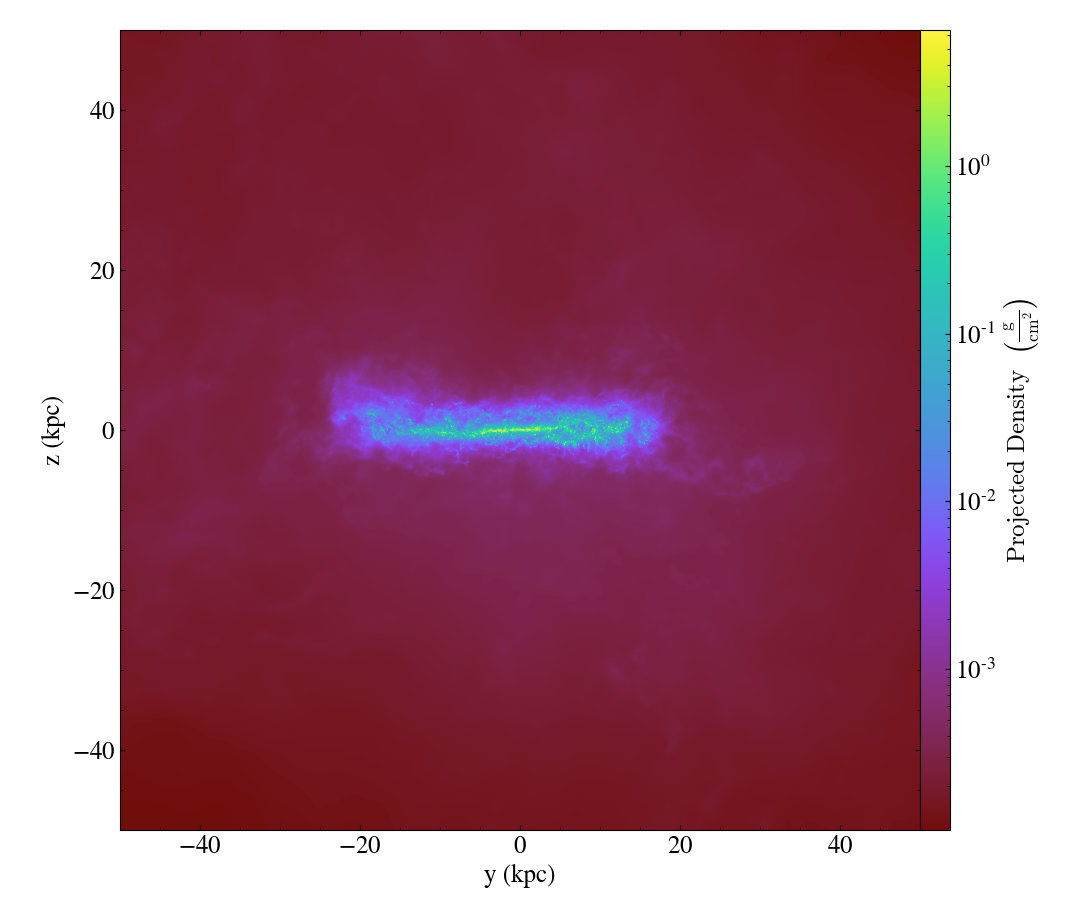

In [385]:
"""
the normal vector is the distance from the center to the sun along the plane of the galaxy (x axis)
the north_vector is jtot, aka zhat. (unit vector of angular momentum vector)

"""

prj_off_axis = yt.OffAxisProjectionPlot(
    ds,
    normal=8*xhat*kpc,
    fields=("gas", "density"),
    width=(100, "kpc"),
    center=sp.center, #works bc even tho same as center_kpc, it's in code length units
    north_vector=[-0.4641237788797538, -0.195761311325276 , -0.8638672507200316]
)
prj_off_axis.set_xlabel("y (kpc)")
prj_off_axis.set_ylabel("z (kpc)")
prj_off_axis

### Function for column densities of ions

In [388]:
def yt_column_density_plot(field, width=(100, "kpc"), center=sp.center):
    """ 
    to see trident ion column density, write this for the field argument:
    "<element>_<ionized how many times>_number_density"
    for example, O VI, oxygen ionized 5 times is:
    "O_p5_number_density"
    
    """

    prj_off_axis_column_density = yt.OffAxisProjectionPlot(
        ds,
        normal=8*xhat*kpc,
        fields=field,
        width=width,
        center=center,
        north_vector=[-0.4641237788797538, -0.195761311325276 , -0.8638672507200316]
    )
    prj_off_axis_column_density.set_xlabel("y (kpc)")
    prj_off_axis_column_density.set_ylabel("z (kpc)")
    return prj_off_axis_column_density

yt : [INFO     ] 2022-10-19 12:30:49,345 xlim = -35.100000 35.100000
yt : [INFO     ] 2022-10-19 12:30:49,347 ylim = -35.100000 35.100000
yt : [INFO     ] 2022-10-19 12:30:49,347 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2022-10-19 12:30:49,349 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800
yt : [WARNING  ] 2022-10-19 12:32:23,565 Plotting ('gas', 'Na_p0_number_density'): Both positive and negative values. Min = 0.0 cm**(-2), Max = 1.5745045063149044e+19 cm**(-2).
yt : [WARNING  ] 2022-10-19 12:32:23,566 Switching to symlog colorbar scaling.



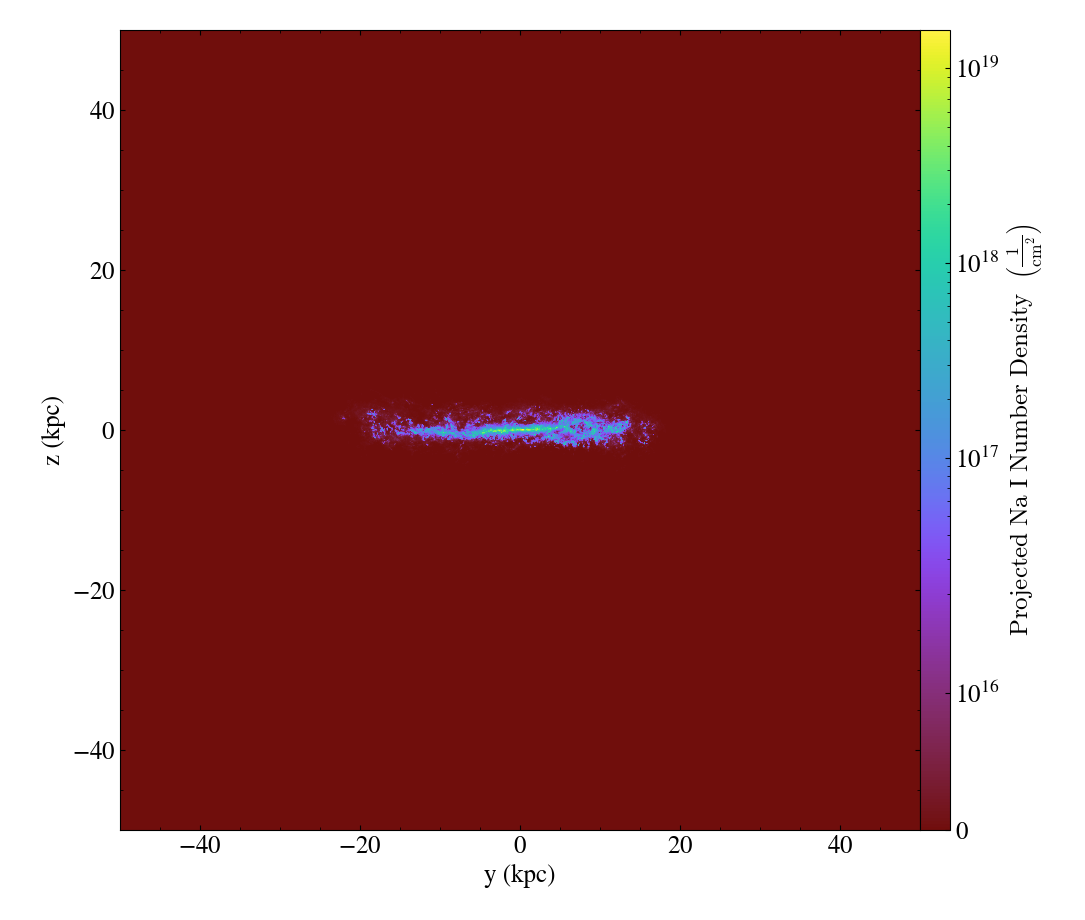

In [407]:
# Na I plot at 100 kpc
yt_column_density_plot("Na_p0_number_density", width=(100,"kpc"))

yt : [INFO     ] 2022-10-19 11:50:02,088 xlim = -21.060000 21.060000
yt : [INFO     ] 2022-10-19 11:50:02,089 ylim = -21.060000 21.060000
yt : [INFO     ] 2022-10-19 11:50:02,090 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2022-10-19 11:50:02,091 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800



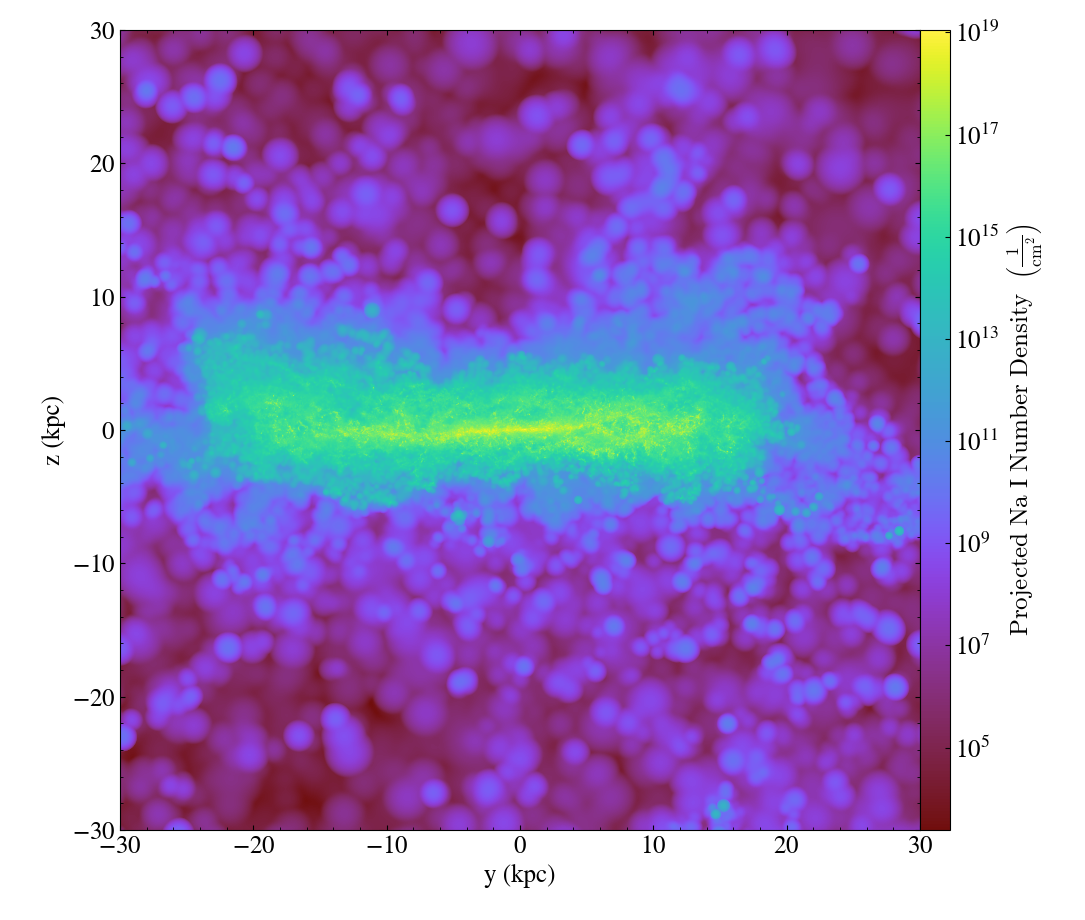

In [389]:
# Na I plot at 60 kpc
yt_column_density_plot("Na_p0_number_density", width=(60,"kpc"))

### Calculating zoom ins by changing the center before processing the image

In [390]:
print(sp.center)

[29338.101914062492 30980.11007812499  32479.913882812492] code_length


In [391]:
#for 3 kpc above mid line (and panned a bit to the left)
print((3*kpc).in_units("code_length"))

2.1059999999999994 code_length


In [397]:
# new center values:
new_center_3kpc = [29338.101914062492, 30980.11007812499, (32479.913882812492 - 2.1059999999999994) ] 

yt : [INFO     ] 2022-10-19 12:01:37,102 xlim = -21.060000 21.060000
yt : [INFO     ] 2022-10-19 12:01:37,103 ylim = -21.060000 21.060000
yt : [INFO     ] 2022-10-19 12:01:37,104 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2022-10-19 12:01:37,105 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800



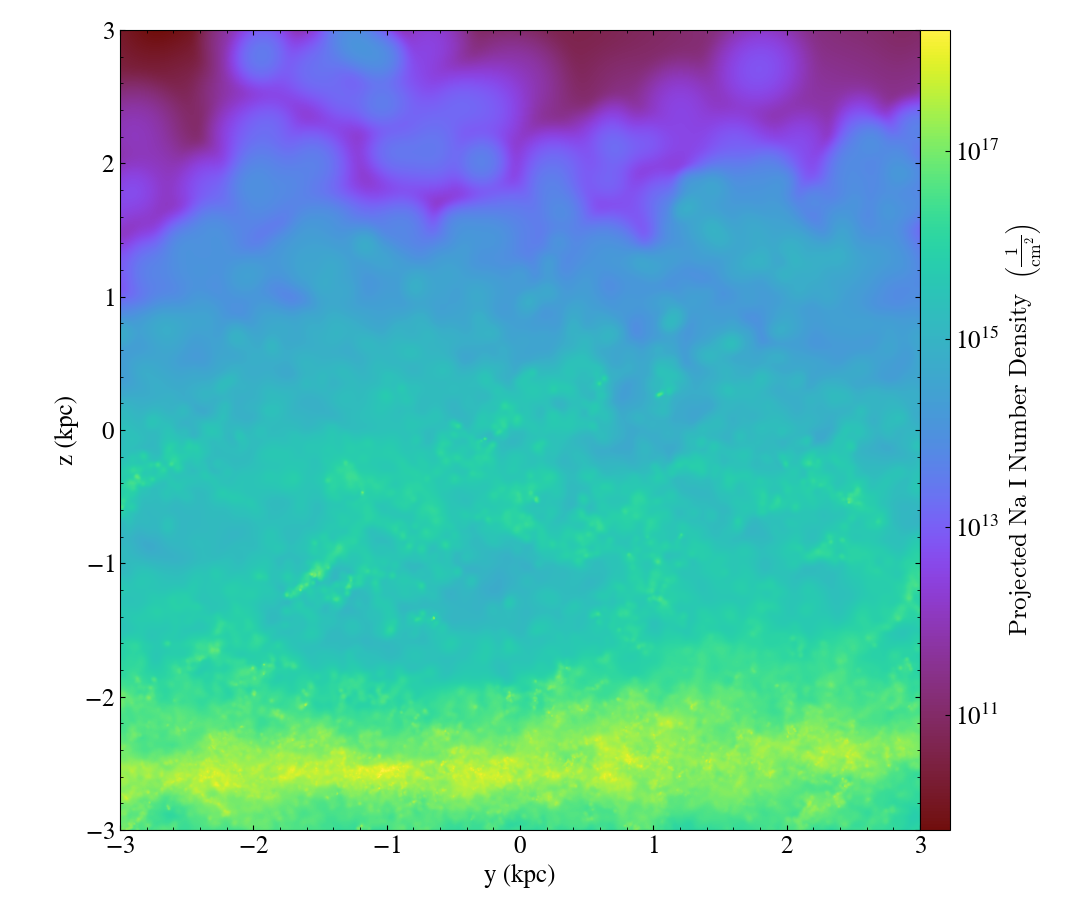

In [398]:
# Na I zoomed in 3 kpc above mid line
Na_3kpc_above = yt_column_density_plot("Na_p0_number_density", width=(60,"kpc"), center=new_center_3kpc)
Na_3kpc_above.zoom(10)


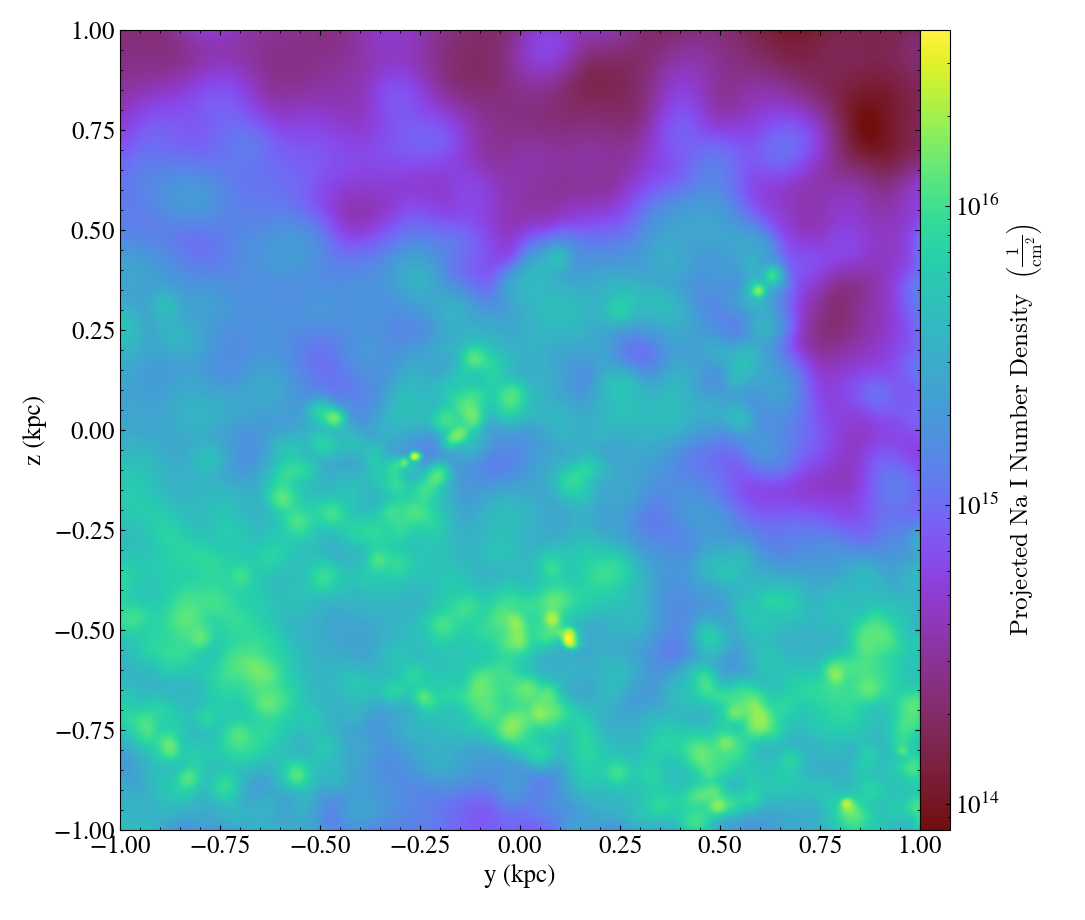

In [399]:
#getting to the width = 2 kpc
Na_3kpc_above.zoom(3)

In [400]:
#for new center at (5,5)
print((5*kpc).in_units("code_length"))

3.5099999999999993 code_length


In [404]:
new_center_5kpc = [29338.101914062492,
                   30980.11007812499 -3.5099999999999993,
                   32479.913882812492 -3.5099999999999993 ]

yt : [INFO     ] 2022-10-19 12:17:48,568 xlim = -21.060000 21.060000
yt : [INFO     ] 2022-10-19 12:17:48,569 ylim = -21.060000 21.060000
yt : [INFO     ] 2022-10-19 12:17:48,569 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2022-10-19 12:17:48,571 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800



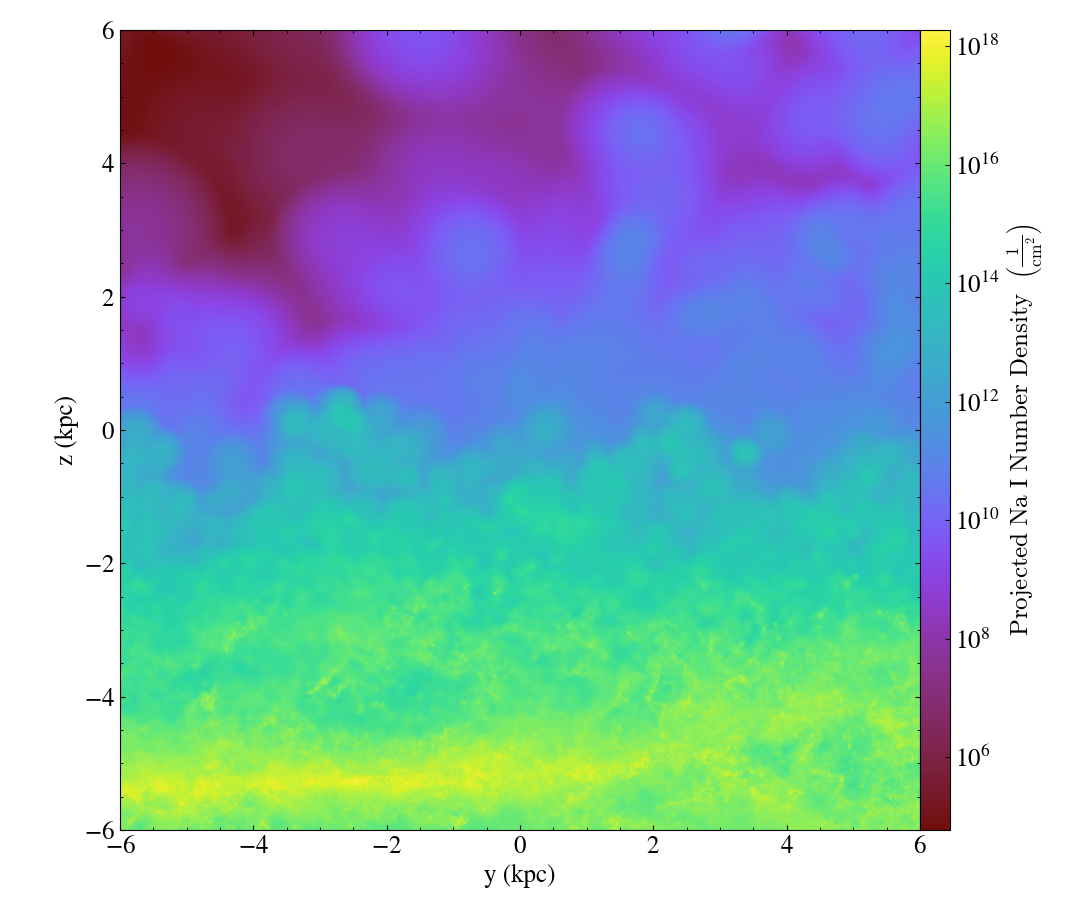

In [405]:
Na_5kpc_5kpc = yt_column_density_plot("Na_p0_number_density", width=(60,"kpc"), center=new_center_5kpc)
Na_5kpc_5kpc.zoom(5)


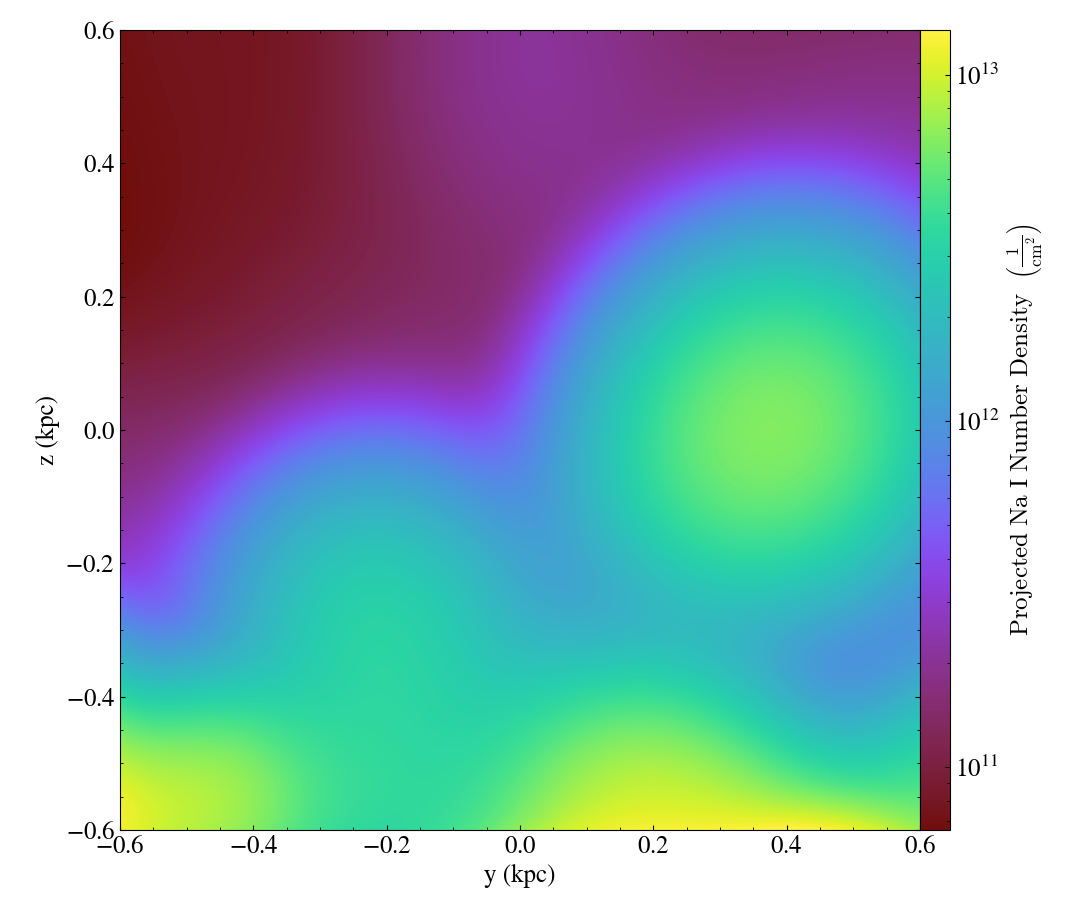

In [406]:
Na_5kpc_5kpc.zoom(10)